In [22]:
# Standard modules
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sunpy.net import Fido, attrs
from sunpy.net.fido_factory import UnifiedResponse
from astropy.time import Time

# Custom modules
from jpm_logger import JpmLogger
from jpm_time_conversions import *

__author__ = 'James Paul Mason'
__contact__ = 'jmason86@gmail.com'


def get_sdo_eve_lines_data(start_time, end_time, 
                           verbose=False):
    """Get emission lines data product from the Solar Dynamics Observatory / Extreme Ultraviolet Variability Experiment.

    Inputs:
        start_time [metatime]: The beginning of the time window of interest. See jpm_time_conversions.py
                               (https://github.com/jmason86/python_convenience_functions/blob/master/jpm_time_conversions.py)
                               for allowed metatime formats.
        end_time [metatime]:   Same as start time but for the end of the time window.
        
    Optional Inputs:
        verbose [bool]: Set to log the processing messages to disk and console. Default is False.

    Outputs:
        TBD
                                                 
    Optional Outputs:
        None

    Example:
        TBD
    """
    return 1

In [2]:
# prototype only: setup for test case
start_time = "2010-09-05 00:00:00"
end_time = "2010-09-05 01:00:00"
%matplotlib inline

In [3]:
results = Fido.search(attrs.Time("2010-09-05 00:00:00", "2010-09-05 01:00:00"), attrs.Instrument('eve'))
results

Start Time [1],End Time [1],Source,Instrument,Type,Wavelength [2]
,,,,,Angstrom
str19,str19,str3,str3,str8,float64
2010-09-05 00:00:00,2010-09-06 00:00:00,SDO,EVE,FULLDISK,1.0 .. 304.0
2010-09-05 00:00:00,2010-09-05 01:00:00,SDO,EVE,FULLDISK,93.0 .. 1033.0
2010-09-05 01:00:00,2010-09-05 02:00:00,SDO,EVE,FULLDISK,93.0 .. 1033.0
2010-09-05 00:00:00,2010-09-05 01:00:00,SDO,EVE,FULLDISK,60.0 .. 1060.0
2010-09-05 01:00:00,2010-09-05 02:00:00,SDO,EVE,FULLDISK,60.0 .. 1060.0
2010-09-05 00:00:00,2010-09-06 00:00:00,SDO,EVE,FULLDISK,1.0 .. 1050.0


The lines are the ones that have wavelength range [93.0 .. 1033.0] so I should be able to use wavemin to filter for them. But as you can see below, that doesn't actually work. It still returns the spectra (wavelength range [60.0 .. 1060.0], which makes no sense because that's not consistent with the input filter criteria. 
I've contacted Joe Gurman of the VSO at GSFC about this. 

In [4]:
from astropy import units as u
results_lines_only = Fido.search(attrs.Time(start_time, end_time), attrs.Instrument('eve'), attrs.Wavelength(wavemin=62 * u.angstrom, wavemax=1035 * u.angstrom))
results_lines_only

Start Time [1],End Time [1],Source,Instrument,Type,Wavelength [2]
,,,,,Angstrom
str19,str19,str3,str3,str8,float64
2010-09-05 00:00:00,2010-09-05 01:00:00,SDO,EVE,FULLDISK,60.0 .. 1060.0
2010-09-05 01:00:00,2010-09-05 02:00:00,SDO,EVE,FULLDISK,60.0 .. 1060.0
2010-09-05 00:00:00,2010-09-06 00:00:00,SDO,EVE,FULLDISK,1.0 .. 1050.0


In [5]:
# Get the direct response from the VSO and filter for just the lines product
vso_responses = list(results.responses)
toss_indices = []
for i in range(0, len(vso_responses[0])):
    if 'Lines' not in vso_responses[0][i]['info']:
        toss_indices.append(i)
for toss_index in sorted(toss_indices, reverse=True):
    del vso_responses[0][toss_index]

In [8]:
# Convert the filtered response back to the UnifiedResponse and download
results = UnifiedResponse(vso_responses)
files = Fido.fetch(results, path='./{instrument}/{info}/{file}.fits')

[                                        =================================

In [7]:
# Read the files and merge them into a single Dataframe

In [6]:
from sunpy import io

In [9]:
import astropy.io.fits as pyfits
pony = pyfits.open(files[0])

In [10]:
pony.info()

Filename: ./EVE/L2Lines (merged)/evl_l2_2010248_00_006_02_fit.gz.4.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU       4   ()      
  1  LinesMeta     1 BinTableHDU     47   39R x 7C   [E, E, E, E, 8A, 5A, 13A]   
  2  BandsMeta     1 BinTableHDU     31   20R x 4C   [13A, 4A, E, E]   
  3  DiodeMeta     1 BinTableHDU     26   6R x 2C   [4A, 6A]   
  4  QuadMeta      1 BinTableHDU     26   4R x 2C   [2A, 3A]   
  5  LinesData     1 BinTableHDU    114   360R x 19C   [D, J, D, B, B, 39E, 39E, 39E, 20E, 20E, 20E, 6E, 6E, 6E, 6E, 4E, 4E, 4E, 4E]   
  6  LinesDataUnits    1 BinTableHDU     58   1R x 19C   [87A, 62A, 65A, 49A, 81A, 171A, 18A, 17A, 242A, 18A, 17A, 59A, 72A, 18A, 66A, 135A, 72A, 49A, 75A]   


In [11]:
names = pony[1].data['NAME']
wavelengths = pony[1].data['WAVE_CENTER']
wavelengths_str = []
[wavelengths_str.append('{0:1.1f}'.format(wavelength)) for wavelength in wavelengths]
line_irradiance = pony[5].data['LINE_IRRADIANCE']
yyyydoy = pony[5].data['YYYYDOY']
sod = pony[5].data['SOD']
eve_dt = yyyydoy_sod_to_datetime(yyyydoy, sod)

In [215]:
#pony[5].header

In [30]:
tai = pony[5].data['TAI']

In [33]:
tai[0]

1662336032.0622907

In [359]:
df = pd.DataFrame(line_irradiance,columns=wavelengths_str, index=eve_dt)

In [360]:
print(len(df))
df.head()

360


,9.4,13.1,13.3,17.1,17.7,18.0,19.5,20.2,21.1,25.6,...,71.9,72.2,77.0,79.0,83.6,95.0,97.3,97.7,102.6,103.2
2010-09-05 23:59:58,-1.000000,-1.000000,-1.000000e+00,-1.000000,-1.000000,-1.00000,-1.000000,-1.00000,-1.000000,-1.000000,...,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0
2010-09-05 00:00:08,0.000004,0.000002,7.554066e-07,0.000056,0.000036,0.00005,0.000037,0.00003,0.000017,0.000030,...,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0
2010-09-05 00:00:18,0.000004,0.000002,7.535070e-07,0.000057,0.000037,0.00005,0.000037,0.00003,0.000017,0.000030,...,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0
2010-09-05 00:00:28,0.000004,0.000002,7.084093e-07,0.000056,0.000037,0.00005,0.000036,0.00003,0.000018,0.000031,...,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0
2010-09-05 00:00:38,0.000004,0.000002,7.334931e-07,0.000055,0.000036,0.00005,0.000037,0.00003,0.000017,0.000030,...,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0


# Figuring out how sunpy timeseries stores its data

In [1]:
import sunpy.timeseries
import sunpy.data.sample
lyra = sunpy.timeseries.TimeSeries(sunpy.data.sample.LYRA_LEVEL3_TIMESERIES)

In [227]:
type(lyra)

sunpy.timeseries.sources.lyra.LYRATimeSeries

In [210]:
lyra.data.head()

,CHANNEL1,CHANNEL2,CHANNEL3,CHANNEL4
2011-06-07 00:00:00.010,0.006365,0.695866,0.002392,0.001100
2011-06-07 00:01:00.010,0.006365,0.695868,0.002392,0.001100
2011-06-07 00:02:00.010,0.006366,0.695870,0.002391,0.001100
2011-06-07 00:03:00.010,0.006366,0.695870,0.002391,0.001099
2011-06-07 00:04:00.010,0.006365,0.695873,0.002391,0.001099


In [228]:
type(lyra.data['CHANNEL1'].values[0])

numpy.float64

/Users/jmason86/anaconda/envs/py36/lib/python3.6/site-packages/pandas/plotting/_core.py:1729: UserWarning: To output multiple subplots, the figure containing the passed axes is being cleared
  plot_obj.generate()
/Users/jmason86/anaconda/envs/py36/lib/python3.6/site-packages/matplotlib/figure.py:403: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


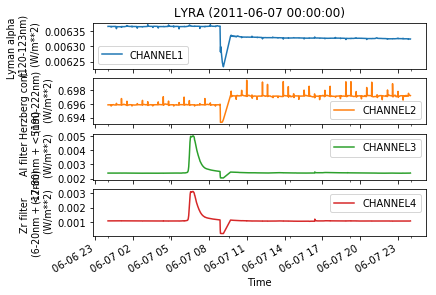

In [2]:
lyra.peek()

In [217]:
rhessi = sunpy.timeseries.TimeSeries(sunpy.data.sample.RHESSI_TIMESERIES)

In [218]:
rhessi.data.head()

,3 - 6 keV,6 - 12 keV,12 - 25 keV,25 - 50 keV,50 - 100 keV,100 - 300 keV,300 - 800 keV,800 - 7000 keV,7000 - 20000 keV
2011-06-07 00:00:00,9,18,15,20,48,136,112,88,3
2011-06-07 00:00:04,8,18,16,22,48,136,108,88,4
2011-06-07 00:00:08,8,16,16,20,48,136,112,88,4
2011-06-07 00:00:12,8,20,18,22,48,136,112,88,4
2011-06-07 00:00:16,9,16,15,22,44,136,112,88,4


In [220]:
type(rhessi)

sunpy.timeseries.sources.rhessi.RHESSISummaryTimeSeries

In [225]:
type(rhessi.data['3 - 6 keV'].values[0])

numpy.int64

/Users/jmason86/anaconda/envs/py36/lib/python3.6/site-packages/matplotlib/figure.py:403: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


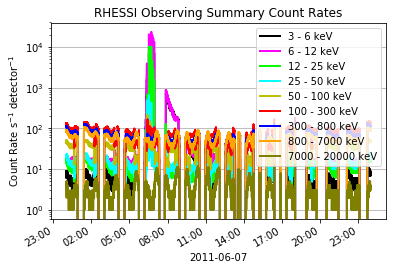

In [237]:
rhessi.peek()

In [ ]:
# Optionally average the data

In [ ]:
# Optionally change the missing data flag from -1 to user desired value

# Figuring out how to do astropy.time subclasses

## utime 

In [71]:
from astropy.time.formats import erfa, TimeFromEpoch
class TimeUTime(TimeFromEpoch):
    """
    Seconds from 1979-01-01 00:00:00 TAI. Similar to Unix time
    but this starts 9 years later.
    """
    name = 'utime'
    unit = 1.0 / erfa.DAYSEC  # in days (1 day == 86400 seconds)
    epoch_val = '1979-01-01 00:00:00'
    epoch_val2 = None
    epoch_scale = 'utc'  # Scale for epoch_val class attribute
    epoch_format = 'iso'  # Format for epoch_val class attribute

In [175]:
t = Time('2000-01-01T13:53:23')
print(t.utime)

662738003.0


In [202]:
t = Time(662738003.0, format='utime')

ScaleValueError: Cannot convert from 'utime' epoch scale 'utc'to specified scale 'utc', got error:
Input values did not match the format class jd

## Astropy doc example for yyyydoyThh:mm:ss

In [188]:
from astropy.time import TimeISO
class TimeYearDayTimeCustom(TimeISO):
    name = 'yday_custom'  # Unique format name
    subfmts = (('date_hms',
                '%Y-%jT%H:%M:%S',
                '{year:d}-{yday:03d}T{hour:02d}:{min:02d}:{sec:02d}'),
               ('date_hm',
                '%Y-%jT%H:%M',
                '{year:d}-{yday:03d}T{hour:02d}:{min:02d}'),
               ('date',
                '%Y-%j',
                '{year:d}-{yday:03d}'))

In [189]:
t = Time('2000-01-01')
t.yday_custom

'2000-001T00:00:00.000'

In [190]:
t2 = Time('2016-001T00:00:00')
t2.iso

'2016-01-01 00:00:00.000'

In [206]:
list(Time.FORMATS)

['jd',
 'mjd',
 'decimalyear',
 'unix',
 'cxcsec',
 'gps',
 'plot_date',
 'datetime',
 'iso',
 'isot',
 'yday',
 'fits',
 'byear',
 'jyear',
 'byear_str',
 'jyear_str',
 'unix_leap',
 'utime',
 'yyyydoy_sod',
 'yday_custom']

In [199]:
t3 = Time('2016-001T00:00:00', format='yday_custom')
t3.iso

'2016-01-01 00:00:00.000'

## Astropy example for unix time with leap seconds (change scaled utc->tai)

In [ ]:
from astropy.time.formats import erfa, TimeFromEpoch
class TimeUnixLeap(TimeFromEpoch):
    name = 'unix_leap'
    unit = 1.0 / erfa.DAYSEC  # in days (1 day == 86400 seconds)
    epoch_val = '1970-01-01 00:00:00'
    epoch_val2 = None
    epoch_scale = 'tai'  # Scale for epoch_val class attribute
    epoch_format = 'iso'  # Format for epoch_val class attribute

In [203]:
t = Time('2000-01-01')
t.unix_leap

946684832.0

In [204]:
t.unix_leap - t.unix

32.0

In [205]:
t2 = Time(946684832.0, format='unix_leap')

ScaleValueError: Cannot convert from 'unix_leap' epoch scale 'tai'to specified scale 'tai', got error:
Input values did not match the format class jd

## How to get yyyydoy and sod in

In [76]:
from astropy.time import TimeFormat

In [161]:
class TimeYYYYDOYSOD(TimeFormat):
    """
    yyyydoy, sod time format, e.g., 2018013, 86399
    which corresponds to 2018-01-13T23:59:59.
    """
    name = 'yyyydoy_sod'  # Unique format name
    
    def __init__(self, yyyydoy, sod):
        super(TimeYYYYDOYSOD, self).__init__(yyyydoy, sod, None, None,
                                             None, None, from_jd=False)
        
    def set_jds(self, yyyydoy, sod):
        """
        Set the internal jd1 and jd2 values from the input yyyydoy, sod.
        The input values are expected to conform to this format, as
        validated by self._check_val_type(yyyydoy, sod) during __init__.
        """        
        self._check_scale(self._scale)  # Validate scale.
        self.jd1, self.jd2 = self.convert_to_jd(yyyydoy, sod)

    @property
    def value(self):
        """
        Return format ``value`` property from internal jd1, jd2.
        """
        return self.jd1 + self.jd2
    
    def _check_val_type(self, yyyydoy, sod):
        """Input value validation, overriding the superclass implementation."""
        if not (np.issubdtype(yyyydoy.dtype, np.number) and np.all(np.isfinite(yyyydoy)) and
                np.issubdtype(sod.dtype, np.number) and np.all(np.isfinite(sod))):
            raise TypeError('Input yyyydoy and sod for {0} class must be finite numbers'.format(self.name))
        
        if np.any(sod >= 86400):
            raise ValueError('Input sod (seconds of day) cannot exceed 86400.')
        
        parsed_date = np.modf(yyyydoy / 1000)  # Divide to get yyyy.doy
        if np.any(parsed_date[0] > 366):
            raise ValueError('The day of year (doy) component of yyyydoy cannot exceed 366.')
        
        def asarray_or_scalar(val):
            """
            Remove ndarray subclasses since for jd1/jd2 we want a pure ndarray
            or a Python or numpy scalar.
            """
            return np.asarray(val) if isinstance(val, np.ndarray) else val

        return asarray_or_scalar(yyyydoy), asarray_or_scalar(sod)

    def convert_to_jd(self, yyyydoy, sod):
        """Convert yyyydoy and sod to julian date.

        Inputs:
            yyyydoy [np.array, numeric dtype]: The array of dates to convert.
            sod [np.array, numeric dtype]:     The array of seconds of day to convert.

        Optional Inputs:
            None

        Outputs:
            jd1 [np.array of floats]: The integer part of the converted julian dates.
            jd2 [np.array of floats]: The fractional part of the converted julian dates.

        Optional Outputs:
            None

        Example:
            jd1, jd2 = convert_to_jd(2018013, 86399)
        """
        
        # Parse year and doy
        parsed_date = np.modf(yyyydoy / 1000)  # Divide to get yyyy.doy
        
        # Convert sod to hh:mm:ss
        # Parse seconds of day into hours, minutes, and seconds
        time = sod % (24 * 3600)
        time = time.astype(int)
        hours = time // 3600
        time %= 3600
        minutes = time // 60
        time %= 60
        seconds = time

        # Convert to string type and add leading zeros
        hours_str = hours.astype(str)
        small_hour_indices = hours < 10
        hours_str[small_hour_indices] = np.core.defchararray.zfill(hours_str[small_hour_indices], 2)
        minutes_str = minutes.astype(str)
        small_minute_indices = minutes < 10
        minutes_str[small_minute_indices] = np.core.defchararray.zfill(minutes_str[small_minute_indices], 2)
        seconds_str = seconds.astype(str)
        small_second_indices = seconds < 10
        seconds_str[small_second_indices] = np.core.defchararray.zfill(seconds_str[small_second_indices], 2)
        hhmmss = np.char.array(hours_str) + ':' + np.char.array(minutes_str) + ':' + np.char.array(seconds_str)
        
        # Create a datetime.datetime array
        dt = np.array([datetime.datetime(int(parsed_date[1][i]), 1, 1,
                      int(hhmmss[i][:2]),
                      int(hhmmss[i][3:5]),
                      int(hhmmss[i][6:8])) +                                      # base (yyyy-01-01 hh:mm:ss)
                      datetime.timedelta(days=int(parsed_date[0][i] * 1000) - 1)  # doy -> mm-dd
                      for i in range(len(yyyydoy))])                              # loop over input array
        
        # Convert to astropy.time.Time
        astroTime = Time(dt)
        return astroTime.jd1, astroTime.jd2

In [174]:
t = Time('2000-01-01T13:53:23')
#print(t.yyyydoy_sod)

In [162]:
t = TimeYYYYDOYSOD(yyyydoy, sod)

In [168]:
t2 = Time(t)

ValueError: Input values did not match any of the formats where the format keyword is optional ['datetime', 'iso', 'isot', 'yday', 'fits', 'byear_str', 'jyear_str']

In [ ]:
# Return the EVE lines data with any optional modifications
return tbd